In [4]:
import os
os.chdir(os.path.pardir)

import numpy as np
import pandas as pd
import time
import itertools
from itertools import product

from regain.covariance import GraphicalLasso as rg_GL
from regain import datasets, utils

from sklearn.covariance import GraphicalLasso as sk_GL
from sklearn import set_config

from regain_benchmark import regain_time
from sklearn_benchmark import sklearn_time
from gglasso_benchmark import call_gglasso, gglasso_time

from utilita import network_generation, model_solution, benchmark_parameters 
from utilita import sparsity_benchmark, dict_shape, calc_hamming_dict, benchmarks_dataframe
# best_time_dataframe, drop_acc_duplicates

from plots import plot_accuracy, plot_scalability, plot_lambdas, plot_bm

from tqdm.contrib import tzip
from tqdm.contrib.itertools import product

set_config(print_changed_only=False)
pd.set_option('display.max_columns', None)

## Data

### Power networks

In [10]:
S_dict=dict()
X_dict=dict()
Theta_dict=dict()

# p_list=[100, 500, 1000, 2000]
# N_list=[200, 1000, 2000, 4000]
p_list=[100, 200]
N_list=[200, 400]

print(" Power network generation ".center(40, '-'))

for p, N in tzip(p_list, N_list):
    start = time.perf_counter()
    S, X, Theta = network_generation(p, N, M=10)
    end = time.perf_counter()
    print("p: %5d, N : %5d, Time : %5.4f" % (p, N, end-start))

    S_dict[p, N] = S.copy()
    X_dict[p, N] = X.copy()
    Theta_dict[p, N] = Theta.copy()

------- Power network generation -------


  0%|          | 0/2 [00:00<?, ?it/s]

p:   100, N :   200, Time : 0.0291
p:   200, N :   400, Time : 0.0677


In [11]:
print("\n Shape of S_i:", dict_shape(S_dict))
print("\n Shape of X_i:", dict_shape(X_dict))
print("\n Shape of Theta_i:", dict_shape(Theta_dict))


 Shape of S_i: [(100, 100), (200, 200)]

 Shape of X_i: [(200, 100), (400, 200)]

 Shape of Theta_i: [(100, 100), (200, 200)]


### Hyperparameters

In [12]:
lambda_list = [0.5, 0.1, 0.05]
sk_params, rg_params, gglasso_params, lambda_list = benchmark_parameters(lambda_list = lambda_list)


 Sklearn model parameters: {'tol': [0.1, 0.01], 'enet': [0.1, 0.01]}

 Regain model parameters: {'tol': [0.0001, 1e-05, 1e-06], 'rtol': [0.0001, 1e-05, 1e-06]}

 ADMM model parameters: {'tol': [1e-05, 1e-06, 1e-07], 'rtol': [1e-05, 1e-06, 1e-07], 'stop': 'boyd', 'method': ['single', 'block']}

 Lambda list: [0.5, 0.1, 0.05]


### Model solution

In [13]:
model_time_dict = dict()
model_Z_dict = dict()
reference_solver = "regain"

print(f"Solving for a reference solution with solver {reference_solver}:")

for X, l1 in product(list(X_dict.values()), lambda_list):
    
    Z, Z_time, info = model_solution(solver=reference_solver, X=X, lambda1=l1)
    
    key = "p_" + str(X.shape[1]) + "_N_" + str(X.shape[0]) + "_l1_" + str(l1)
    model_time_dict.update({key: Z_time})
    model_Z_dict.update({key: Z})

Solving for a reference solution with solver regain:


  0%|          | 0/6 [00:00<?, ?it/s]

obj: 80.2886, rnorm: 15.2313, snorm: 17.7772,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.4769, rnorm: 5.5011, snorm: 3.1702,eps_pri: 0.0000, eps_dual: 0.0000
obj: 128.2025, rnorm: 2.7162, snorm: 2.5411,eps_pri: 0.0000, eps_dual: 0.0000
obj: 121.4142, rnorm: 1.4973, snorm: 1.7086,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.7886, rnorm: 0.8985, snorm: 1.0272,eps_pri: 0.0000, eps_dual: 0.0000
obj: 117.8356, rnorm: 0.5766, snorm: 0.5740,eps_pri: 0.0000, eps_dual: 0.0000
obj: 117.5285, rnorm: 0.3883, snorm: 0.3138,eps_pri: 0.0000, eps_dual: 0.0000
obj: 117.4382, rnorm: 0.2733, snorm: 0.1711,eps_pri: 0.0000, eps_dual: 0.0000
obj: 117.4640, rnorm: 0.2004, snorm: 0.0981,eps_pri: 0.0000, eps_dual: 0.0000
obj: 117.5189, rnorm: 0.1553, snorm: 0.0563,eps_pri: 0.0000, eps_dual: 0.0000
obj: 117.5807, rnorm: 0.1258, snorm: 0.0327,eps_pri: 0.0000, eps_dual: 0.0000
obj: 117.6422, rnorm: 0.1054, snorm: 0.0198,eps_pri: 0.0000, eps_dual: 0.0000
obj: 117.6989, rnorm: 0.0902, snorm: 0.0123,eps_pri: 0.0000, ep

obj: 118.0721, rnorm: 0.0006, snorm: 0.0002,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0723, rnorm: 0.0005, snorm: 0.0002,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0724, rnorm: 0.0004, snorm: 0.0002,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0725, rnorm: 0.0004, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0726, rnorm: 0.0003, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0727, rnorm: 0.0002, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0728, rnorm: 0.0002, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0728, rnorm: 0.0002, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0729, rnorm: 0.0001, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0729, rnorm: 0.0001, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0729, rnorm: 0.0001, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0729, rnorm: 0.0001, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 118.0730, rnorm: 0.0001, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 108.4858, rnorm: 0.0009, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4859, rnorm: 0.0008, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4859, rnorm: 0.0007, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4859, rnorm: 0.0007, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4860, rnorm: 0.0006, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4860, rnorm: 0.0006, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4860, rnorm: 0.0005, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4861, rnorm: 0.0005, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4861, rnorm: 0.0004, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4861, rnorm: 0.0004, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4861, rnorm: 0.0003, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4861, rnorm: 0.0003, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4861, rnorm: 0.0003, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 108.4862, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 101.5931, rnorm: 0.0002, snorm: 0.0003,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0002, snorm: 0.0002,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0002, snorm: 0.0002,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0001, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0001, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0001, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0001, snorm: 0.0001,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0001, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 101.5931, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 157.2317, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 223.5844, rnorm: 7.0781, snorm: 8.6585,eps_pri: 0.0000, eps_dual: 0.0000
obj: 190.8482, rnorm: 4.6195, snorm: 5.3979,eps_pri: 0.0000, eps_dual: 0.0000
obj: 172.5955, rnorm: 2.5406, snorm: 3.6096,eps_pri: 0.0000, eps_dual: 0.0000
obj: 162.1553, rnorm: 1.3881, snorm: 2.5169,eps_pri: 0.0000, eps_dual: 0.0000
obj: 156.3165, rnorm: 0.7591, snorm: 1.8188,eps_pri: 0.0000, eps_dual: 0.0000
obj: 153.1124, rnorm: 0.4192, snorm: 1.3353,eps_pri: 0.0000, eps_dual: 0.0000
obj: 151.4602, rnorm: 0.2482, snorm: 0.9804,eps_pri: 0.0000, eps_dual: 0.0000
obj: 150.6189, rnorm: 0.1594, snorm: 0.7153,eps_pri: 0.0000, eps_dual: 0.0000
obj: 150.2193, rnorm: 0.1184, snorm: 0.5162,eps_pri: 0.0000, eps_dual: 0.0000
obj: 150.0343, rnorm: 0.0941, snorm: 0.3702,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9483, rnorm: 0.0738, snorm: 0.2645,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9186, rnorm: 0.0596, snorm: 0.1881,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9070, rnorm: 0.0481, snorm: 0.1338,eps_pri: 0.0000, eps

obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 149.9496, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps

obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps_dual: 0.0000
obj: 143.2099, rnorm: 0.0000, snorm: 0.0000,eps_pri: 0.0000, eps

In [14]:
time_dict = dict()
accuracy_dict = dict()
Z_dict = dict()

n_iter = 2

### GGLasso

In [15]:
for X, S in tzip(list(X_dict.values()), list(S_dict.values())):
    Omega_0 = np.eye(len(S))
    gg_time, gg_accuracy, Z_gg = gglasso_time(S=S, X=X, Omega_0=Omega_0, Z=model_Z_dict, lambda_list=lambda_list,
                                              n_iter=n_iter, gglasso_params=gglasso_params, warm_start=False)
    
    time_dict.update(gg_time)
    accuracy_dict.update(gg_accuracy)
    Z_dict.update(Z_gg)

  0%|          | 0/2 [00:00<?, ?it/s]

######## NUMBA WARMUP ###########



single-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  9.13it/s]

ADMM terminated after 5 iterations with status: max iterations reached.
ADMM terminated after 5 iterations with status: max iterations reached.
##################################
ADMM terminated after 20 iterations with status: optimal.


single-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]

single-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 18.78it/s]

single-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 27.39it/s]

single-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.



single-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 12.39it/s]

single-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 20.61it/s]

single-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.



single-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 18.20it/s]

single-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 15.18it/s]

single-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.



single-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 16.15it/s]

single-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 17.23it/s]

single-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s]
single-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

single-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 53 iterations with status: optimal.
ADMM terminated after 53 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s]
single-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

single-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 13.35it/s]

single-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s]
single-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

single-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 54 iterations with status: optimal.
ADMM terminated after 54 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

single-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 18.75it/s]

single-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s]
single-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  7.75it/s]

single-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 54 iterations with status: optimal.
ADMM terminated after 54 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 15.18it/s]

single-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 20.08it/s]

single-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s]

ADMM terminated after 95 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

single-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s]

ADMM terminated after 95 iterations with status: optimal.
ADMM terminated after 47 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

single-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 14.12it/s]

single-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 47 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s]

ADMM terminated after 98 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

single-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s]

ADMM terminated after 98 iterations with status: optimal.
ADMM terminated after 48 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]

single-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 16.17it/s]

single-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 48 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s]

ADMM terminated after 98 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

single-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s]

ADMM terminated after 98 iterations with status: optimal.
ADMM terminated after 49 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  7.75it/s]

single-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 14.69it/s]

block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 49 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.5: 63 connected components.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 17 iterations with status: opti

block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 31.48it/s]

block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 26.00it/s]

block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 28.41it/s]

block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]


ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.5: 63 connected components.
ADMM terminated after 12 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 12 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 11 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 11 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 18 iterations 

block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 30.26it/s]

block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 24.90it/s]

block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 28.06it/s]

block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.5: 63 connected components.
ADMM terminated after 12 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 12 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 11 iterations with status: optimal.
block-boyd_tol_1e

block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 30.01it/s]

block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 25.92it/s]

block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.5: 63 connected components.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.5: 6


block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 17.35it/s]

block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 26.03it/s]

block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 11 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.5: 63 connected components.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 18 iteration


block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s]

block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 21.43it/s]

block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 29.15it/s]

block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 27 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
block-boyd_tol_1


block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 11.89it/s]

block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 27 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 27 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.05: 1 connected components.



block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 13.47it/s]

block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 27.63it/s]

block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.5: 63 connected components.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 19 iteration


block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]

block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 13.62it/s]

block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 27 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
block-boyd_tol_1

block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 26.00it/s]

block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.5: 63 connected components.



block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s]
block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 47 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 47 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.1: 1 connected components.



block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]

block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 24.98it/s]

block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 26 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 26 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.5: 63 connected components.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated


block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s]
block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 48 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 48 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.1: 1 connected components.



block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]

block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 25.54it/s]

block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 26 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 26 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.5: 63 connected components.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated


block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s]
block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 49 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.1: 1 connected components.
ADMM terminated after 49 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.1: 1 connected components.



block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s]
block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

ADMM terminated after 26 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.05: 1 connected components.
ADMM terminated after 26 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.05: 1 connected components.
######## NUMBA WARMUP ###########
ADMM terminated after 5 iterations with status: max iterations reached.
ADMM terminated after 5 iterations with status: max iterations reached.




single-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

single-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

##################################
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.



single-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 14.86it/s]

single-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s]

ADMM terminated after 7 iterations with status: optimal.
ADMM terminated after 7 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.


single-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]

single-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s]

single-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.



single-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]

single-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 7 iterations with status: optimal.
ADMM terminated after 7 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.



single-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]

single-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 14.55it/s]

single-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.
ADMM terminated after 8 iterations with status: optimal.



single-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 16.03it/s]

single-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 7 iterations with status: optimal.
ADMM terminated after 7 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.



single-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

single-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 9 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s]
single-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

single-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s]
single-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

single-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s]
single-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

single-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s]

ADMM terminated after 21 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

single-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s]

ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

single-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  8.94it/s]

ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]

single-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s]

ADMM terminated after 17 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

single-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s]

ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

single-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 17 iterations with status: optimal.



single-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s]
single-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 17 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s]

ADMM terminated after 40 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 40 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  3.64it/s]

ADMM terminated after 36 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 36 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s]
single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

single-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s]

ADMM terminated after 40 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

single-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 40 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s]

ADMM terminated after 37 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

single-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 37 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s]
single-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

single-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s]

ADMM terminated after 40 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

single-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 40 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s]

ADMM terminated after 37 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

single-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
single-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s]

ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.



single-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 37.10it/s]

block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 21.70it/s]

block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 7 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.1: 8 connected components.
ADMM terminated after 7 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 13.19it/s]

block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 38.55it/s]

block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 9 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 9 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 7 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.1: 8 connected components.


block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 21.77it/s]

block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 14.82it/s]

block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 7 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.1: 8 connected components.
ADMM terminated after 9 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 9 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.


block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 35.23it/s]

block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]
block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 14.26it/s]

block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 7 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.1: 8 connected components.
ADMM terminated after 7 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]

block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 35.32it/s]

block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 9 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 9 iterations with status: optimal.
block-boyd_tol_1e-05_rtol_1e-07_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.5: 175 connected components.



block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s]
block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.1: 8 connected components.
ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s]

ADMM terminated after 17 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.05: 1 connected components.



block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 29.96it/s]

block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 17 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.5: 175 connected components.



block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s]

ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]
block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s]

ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.1: 8 connected components.
ADMM terminated after 17 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.05: 1 connected components.



block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 33.18it/s]

block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 17 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.5: 175 connected components.



block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s]

ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s]

ADMM terminated after 17 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.05: 1 connected components.



block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 31.34it/s]

block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 17 iterations with status: optimal.
block-boyd_tol_1e-06_rtol_1e-07_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 19 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 19 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.5: 175 connected components.



block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  3.12it/s]

ADMM terminated after 36 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 36 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  3.35it/s]

ADMM terminated after 25 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.05: 1 connected components.



block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 31.22it/s]

block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 25 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.5: 175 connected components.



block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s]

ADMM terminated after 37 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 37 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s]

ADMM terminated after 25 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.05: 1 connected components.



block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 31.76it/s]

block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 25 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-06_p_200_N_400_l1_0.05: 1 connected components.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.5: 175 connected components.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.5: 175 connected components.



block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s]

ADMM terminated after 37 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]

ADMM terminated after 37 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.1: 8 connected components.



block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s]

ADMM terminated after 25 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.05: 1 connected components.



block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

ADMM terminated after 25 iterations with status: optimal.
block-boyd_tol_1e-07_rtol_1e-07_p_200_N_400_l1_0.05: 1 connected components.


### Sklearn

In [16]:
for X, S in tzip(list(X_dict.values()), list(S_dict.values())):
    sk_time, sk_accuracy, Z_sk = sklearn_time(X=X, Z=model_Z_dict, sk_params=sk_params, lambda_list=lambda_list, \
                                              n_iter=n_iter)
    
    time_dict.update(sk_time)
    accuracy_dict.update(sk_accuracy)
    Z_dict.update(Z_sk)

  0%|          | 0/2 [00:00<?, ?it/s]


sklearn_tol_0.1_enet_0.1_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 18.62it/s]

sklearn_tol_0.1_enet_0.1_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 21.45it/s]

sklearn_tol_0.1_enet_0.1_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s]

sklearn_tol_0.1_enet_0.01_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 21.38it/s]

sklearn_tol_0.1_enet_0.01_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 24.87it/s]

sklearn_tol_0.1_enet_0.01_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 23.73it/s]

sklearn_tol_0.01_enet_0.1_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 20.40it/s]

sklearn_tol_0.01_enet_0.1_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]

sklearn_tol_0.01_enet_0.1_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]

sklearn_tol_0.01_enet_0.01_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 19.26it/s]

sklearn_tol_0.01_enet_0.01_p_100_N_200_l1_0.1: 100%|██████████| 2/2 

### Regain

In [17]:
for X, S in tzip(list(X_dict.values()), list(S_dict.values())):
    rg_time, rg_accuracy, Z_rg = regain_time(X=X, Z=model_Z_dict, rg_params=rg_params, lambda_list=lambda_list, \
                                             n_iter=n_iter, warm_start=False)
    
    time_dict.update(rg_time)
    accuracy_dict.update(rg_accuracy)
    Z_dict.update(Z_rg)

  0%|          | 0/2 [00:00<?, ?it/s]


regain_tol_0.0001_rtol_0.0001_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':

regain_tol_0.0001_rtol_0.0001_p_100_N_200_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':
regain_tol_0.0001_rtol_0.0001_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]

regain_tol_0.0001_rtol_0.0001_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covari


regain_tol_1e-05_rtol_0.0001_p_100_N_200_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  9.30it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':

regain_tol_1e-05_rtol_0.0001_p_100_N_200_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

regain_tol_1e-05_rtol_0.0001_p_100_N_200_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':
/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scal

regain_tol_1e-06_rtol_0.0001_p_100_N_200_l1_0.05: 100%|██████████| 2/2 [00:00<00:00, 12.27it/s]

regain_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':

regain_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  9.40it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':
regain_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]

regain_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]/U

regain_tol_0.0001_rtol_1e-05_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

regain_tol_0.0001_rtol_1e-05_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':

regain_tol_0.0001_rtol_1e-05_p_200_N_400_l1_0.1:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':

regain_tol_0.0001_rtol_1e-05_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

regain_tol_0.0001_rtol_1e-05_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it


regain_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.1: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

regain_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05:   0%|          | 0/2 [00:00<?, ?it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':

regain_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':

regain_tol_1e-05_rtol_1e-05_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

regain_tol_1e-05_rtol_1e-06_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s


regain_tol_1e-06_rtol_1e-05_p_200_N_400_l1_0.05: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

regain_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.5:   0%|          | 0/2 [00:00<?, ?it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':

regain_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.5:  50%|█████     | 1/2 [00:00<00:00,  1.95it/s]/Users/oleg.vlasovetc/opt/anaconda3/envs/gglasso/lib/python3.8/site-packages/regain/covariance/graphical_lasso_.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mode == 'empirical':

regain_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.5: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

regain_tol_1e-06_rtol_1e-06_p_200_N_400_l1_0.1:   0%|          | 0/2 [00:00<?, ?it/s]/

### Hamming distances

In [18]:
hamming_dict = calc_hamming_dict(Theta_dict=Theta_dict, Z_dict=Z_dict, t_rounding=1e-8)

### Visualization

In [54]:
df["dim"] = list(zip(df.p, df.N))
df["dim"]
# df["p"].values

block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.05    (100, 200)
block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.05    (100, 200)
block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.05    (100, 200)
block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.05    (100, 200)
block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.05    (100, 200)
                                                          ...    
single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.5    (200, 400)
sklearn_tol_0.1_enet_0.01_p_200_N_400_l1_0.5           (200, 400)
sklearn_tol_0.01_enet_0.01_p_200_N_400_l1_0.5          (200, 400)
sklearn_tol_0.1_enet_0.1_p_200_N_400_l1_0.5            (200, 400)
sklearn_tol_0.01_enet_0.1_p_200_N_400_l1_0.5           (200, 400)
Name: dim, Length: 186, dtype: object

In [50]:
df = benchmarks_dataframe(times=time_dict, acc=accuracy_dict, hamming=hamming_dict)
df
# df = drop_acc_duplicates(df)
# df = df.reset_index(drop=True)
# df.head()

,time,accuracy,hamming,method,tol,rtol,p,N,l1
block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.05,0.033854,8.532242e-03,4514,block-boyd,1.000000e-05,1.000000e-05,100,200,0.05
block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.05,0.034337,8.532242e-03,4514,block-boyd,1.000000e-05,1.000000e-06,100,200,0.05
block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.05,0.045341,1.028292e-03,4514,block-boyd,1.000000e-06,1.000000e-05,100,200,0.05
block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.05,0.055483,8.532242e-03,4514,block-boyd,1.000000e-05,1.000000e-07,100,200,0.05
block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.05,0.071139,1.028292e-03,4514,block-boyd,1.000000e-06,1.000000e-07,100,200,0.05
...,...,...,...,...,...,...,...,...,...
single-boyd_tol_1e-07_rtol_1e-05_p_200_N_400_l1_0.5,0.439275,6.093229e-07,330,single-boyd,1.000000e-07,1.000000e-05,200,400,0.50
sklearn_tol_0.1_enet_0.01_p_200_N_400_l1_0.5,0.093609,2.630325e-05,330,sklearn,1.000000e-01,1.000000e-02,200,400,0.50
sklearn_tol_0.01_enet_0.01_p_200_N_400_l1_0.5,0.101773,2.630325e-05,330,sklearn,1.000000e-02,1.000000e-02,200,400,0.50
sklearn_tol_0.1_enet_0.1_p_200_N_400_l1_0.5,0.111146,3.031375e-04,330,sklearn,1.000000e-01,1.000000e-01,200,400,0.50


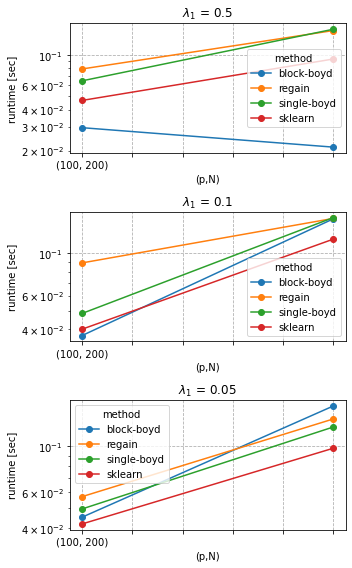

In [29]:
plot_bm(df, lambda_list, min_acc = 5e-3, log_scale = True)

In [61]:
fig = plot_lambdas(df, upper_bound=0.01, lower_bound=0.000001)
fig.show()

In [ ]:
def drop_acc_duplicates(df):
    """
    Drop duplicates of the models showing the same accuracy.
    :param df: pd.DataFrame()
    :return: pd.DataFrame()
    """
    assert 'method' in df.columns
    assert 'accuracy' in df.columns

    unique_acc_df = df[:1]
    for method in df.method.unique():
        filtered = df[df['method'] == method]
        filtered = filtered.drop_duplicates(subset='accuracy', keep='first')
        unique_acc_df = pd.concat([filtered, unique_acc_df])

    return unique_acc_df[:-1]

In [91]:
df[(df['method'] == 'block-boyd') & (df['p'] == 100)].sort_values(by=["accuracy"])

,time,accuracy,hamming,method,tol,rtol,p,N,l1,dim
block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.5,0.037081,3.285213e-07,106,block-boyd,1.000000e-07,1.000000e-07,100,200,0.50,"(100, 200)"
block-boyd_tol_1e-07_rtol_1e-06_p_100_N_200_l1_0.5,0.037653,5.305495e-07,106,block-boyd,1.000000e-07,1.000000e-06,100,200,0.50,"(100, 200)"
block-boyd_tol_1e-07_rtol_1e-05_p_100_N_200_l1_0.5,0.036184,2.604763e-06,106,block-boyd,1.000000e-07,1.000000e-05,100,200,0.50,"(100, 200)"
block-boyd_tol_1e-06_rtol_1e-07_p_100_N_200_l1_0.5,0.034110,3.193960e-06,106,block-boyd,1.000000e-06,1.000000e-07,100,200,0.50,"(100, 200)"
block-boyd_tol_1e-06_rtol_1e-06_p_100_N_200_l1_0.5,0.032187,3.639156e-06,106,block-boyd,1.000000e-06,1.000000e-06,100,200,0.50,"(100, 200)"
block-boyd_tol_1e-06_rtol_1e-05_p_100_N_200_l1_0.5,0.036016,6.165234e-06,106,block-boyd,1.000000e-06,1.000000e-05,100,200,0.50,"(100, 200)"
block-boyd_tol_1e-05_rtol_1e-07_p_100_N_200_l1_0.5,0.031038,3.449255e-05,106,block-boyd,1.000000e-05,1.000000e-07,100,200,0.50,"(100, 200)"
block-boyd_tol_1e-05_rtol_1e-06_p_100_N_200_l1_0.5,0.030810,4.150808e-05,106,block-boyd,1.000000e-05,1.000000e-06,100,200,0.50,"(100, 200)"
block-boyd_tol_1e-05_rtol_1e-05_p_100_N_200_l1_0.5,0.029501,4.150808e-05,106,block-boyd,1.000000e-05,1.000000e-05,100,200,0.50,"(100, 200)"
block-boyd_tol_1e-07_rtol_1e-07_p_100_N_200_l1_0.1,0.158883,6.204469e-05,2042,block-boyd,1.000000e-07,1.000000e-07,100,200,0.10,"(100, 200)"


In [63]:
def plot_accuracy(df=pd.DataFrame(), upper_bound=float, lower_bound=float, lambda_filter=float, sortby=list):
    """
    Plot how accurate the solution of a model with particular hyperparameters
    comparing with the model solution Z.
    :param df: pandas.DataFrame()
    :param upper_bound: float
    Specify the upper bound for the solution accuracy.
    :param lower_bound: float
    Specify the lower bound for the solution accuracy.
    :return: px.scatter()
    """
    df = df.sort_values(by=sortby)

    # filter by lambda
    df = df[df["l1"] == lambda_filter]
    df["dim"] = list(zip(df.p, df.N))

    color_discrete_map = {'block-boyd': '#FF0000', 'regain': '#32CD32',
                          'single-boyd': '#FF8C00', 'sklearn': '#0000FF'}

    fig = px.scatter(df[(df["accuracy"] < upper_bound) & (df["accuracy"] > lower_bound)],
                     y="time", x="accuracy", text="l1", color="method",
                     log_y=True, log_x=True, facet_col='dim', facet_col_wrap=3, color_discrete_map=color_discrete_map,
                     labels={
                         "time": "Time, s",
                         "accuracy": "Accuracy",
                         "method": "method"
                     },
                     template="plotly_white",
                     title="ADMM performance benchmark at lambda={0}.<br>"
                           "Accuracy is between {1} and {2}".format(upper_bound, lower_bound, lambda_filter))

    fig.update_traces(mode='markers+lines', marker_line_width=1, marker_size=10)
    fig.update_xaxes(matches=None)
    fig.update_yaxes(exponentformat="power")

    return fig

In [64]:
fig = plot_accuracy(df, upper_bound=0.1, lower_bound=0.0000001, lambda_filter=0.05, sortby=['p', 'time'])
fig.show()

In [85]:
frames = sparsity_benchmark(df, upper_bound=0.01, lower_bound=0.0001, lambda_filter=0.1)
frames

{100:         method  min_hamming
 0   block-boyd         1992
 1  single-boyd         1992
 2       regain         2032
 3      sklearn         2040,
 200:         method  min_hamming
 0   block-boyd          804
 1       regain          804
 2  single-boyd          804
 3      sklearn          828}

### Latent variables data from <em>regain</em>

In [6]:
# # prepare data
# n_times = [20, 50, 100]
# n_dims = np.sqrt(np.logspace(2, 5, 10)).astype(int)

# n_samples = 200
# n_dim_lat = 2

# np.random.seed(42)
# with utils.suppress_stdout():
#     data = {
#         (dim, T): datasets.make_dataset(
#             mode='ma', n_samples=n_samples, 
#             n_dim_lat=n_dim_lat, n_dim_obs=dim,
#             T=T, epsilon=1e-2)
#         for dim, T in (product(n_dims, n_times))
#     }

# X_lat = dict()

# for key in data.keys():
#     X_lat.update({key:data[key]['data']})
    
# X_lat = list(X_lat.values())
# X_lat = [x for data in X_lat for x in data] #flatten data array
# S_lat = list() # empirical covariance matrices
# for i in X_lat:
#     S_lat.append(np.cov(i))

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# trace_dict = dict()
# for key, item in Z_rg.items():
#         trace_dict.update({key: {"Z": item, "X": X, "S": S,"l1": l1}})

### Import benchmarks

In [ ]:
# import pandas as pd
# obj = pd.read_pickle(r'sklearn_acc_dict.pickle')